## When using a local Jupyter Notebook

In [5]:
%cd C:/Users/nashw/Desktop/ACV/

C:\Users\nashw\Desktop\ACV


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Show an image (in a window)

In [2]:
def show_image(image):
    cv2.imshow("", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
star_mask = cv2.imread("data/star_mask.jpg")

show_image(star_mask)

### Watch a webcam and apply a filter

In [34]:
def run_filter_on_camera(image_filter):
    cap = cv2.VideoCapture(0)

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        result_image = image_filter(frame)

        # Display the resulting frame
        cv2.imshow("frame", result_image)

        # We break out of the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [35]:
def black_and_white(image):
    return_image = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return_image[:, :, 0] = gray
    return_image[:, :, 1] = gray
    return_image[:, :, 2] = gray

    return return_image

In [36]:
run_filter_on_camera(black_and_white)

## Image Transformations

### Resizing

In [ ]:
scalefactor = 2.5

messi = plt.imread("data/messi.jpg")

# the heart of the code:
res = cv2.resize(
    messi, None, fx=scalefactor, fy=scalefactor, interpolation=cv2.INTER_CUBIC
)

# the remainder of the code is to generate the display image
height, width = messi.shape[:2]

bigwidth = int(np.amax([scalefactor * height, height]))
bigheight = int(width * (1 + scalefactor))

bigim = np.zeros((bigwidth, bigheight, 3), np.uint8)
bigim[:height, :width] = messi

if scalefactor > 1:
    bigim[:, width:] = res
else:
    bigim[: int(scalefactor * height), width:] = res

plt.figure()
plt.imshow(bigim)

### Translation

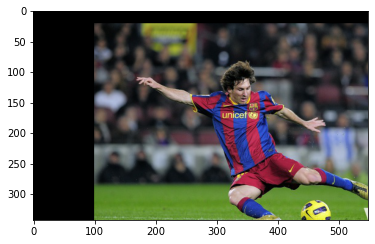

In [11]:
rows, cols, chans = messi.shape

xshift = 100
yshift = 20

M = np.float32([[1, 0, xshift], [0, 1, yshift]])
dst = cv2.warpAffine(messi, M, (cols, rows))

plt.figure()
plt.imshow(dst)

### Rotation

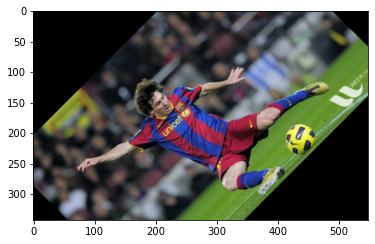

In [12]:
rows, cols, chans = messi.shape

# specify our rotation in degrees
theta = 45.0

M = cv2.getRotationMatrix2D((cols / 2, rows / 2), theta, 1)
dst = cv2.warpAffine(messi, M, (cols, rows))

plt.figure()
plt.imshow(dst)

### General affine transform

Map 3 input (x,y) points to 3 output points (ie triangle to triangle)

Will perform translation, scaling, rotation, and skew, but not perspective correction

(<AxesSubplot:title={'center':'Output'}>,
 Text(0.5, 1.0, 'Output'))

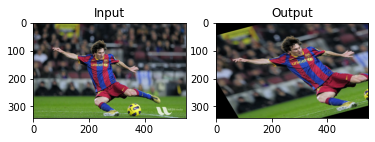

In [14]:
rows, cols, ch = messi.shape

pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])

M = cv2.getAffineTransform(pts1, pts2)

dst = cv2.warpAffine(messi, M, (cols, rows))

plt.figure()
plt.subplot(121), plt.imshow(messi), plt.title("Input")
plt.subplot(122), plt.imshow(dst), plt.title("Output")

### Perspective transform

4 point transform

Nonlinear but more general than affine

Perspective:  further away objects look smaller

In [45]:
img.shape

(342, 548, 3)

In [46]:
dst.shape

(342, 548, 3)

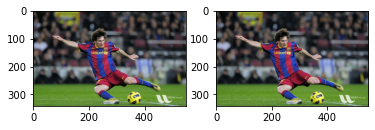

In [57]:
img = plt.imread("data/messi.jpg")
rows, cols, chans = img.shape

startpts = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])
endpts = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])

M = cv2.getPerspectiveTransform(startpts, endpts)

dst = cv2.warpPerspective(img, M, (cols, rows))

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(dst)

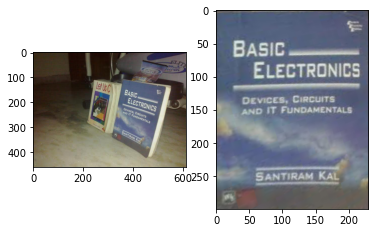

In [16]:
img = plt.imread("data/right.jpg")
rows, cols, chans = img.shape

startpts = np.float32([[362, 107], [530, 139], [453, 416], [319, 337]])
endpts = np.float32([[100, 100], [330, 100], [330, 400], [100, 400]])

M = cv2.getPerspectiveTransform(startpts, endpts)

dst = cv2.warpPerspective(img, M, (rows, cols))

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(dst[100:400, 100:330])

## Mediapipe presentation

In [5]:
import mediapipe as mp

drawing_utils = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles

In [6]:
def run_filter_with_mediapipe_model(mediapipe_model, mediapipe_based_filter):
    cap = cv2.VideoCapture(0)

    with mediapipe_model as model:
        while cap.isOpened():
            success, image = cap.read()

            if not success:
                print("Ignoring empty camera frame.")
                continue  # If loading a video, use 'break' instead of 'continue'.

            # Flip the image horizontally for a later selfie-view display, and convert
            # the BGR image to RGB.
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            results = model.process(image)

            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            result_image = mediapipe_based_filter(image, results)

            cv2.imshow("MediaPipe", result_image)

            if cv2.waitKey(5) & 0xFF == ord("q"):
                break

    cap.release()
    cv2.destroyAllWindows()

### Holistic (Hands, Face and Pose tracking)

In [7]:
Holistic = mp.solutions.holistic.Holistic

In [8]:
def draw_holistic_results(
    image, results, show_hands=True, show_face=True, show_pose=False
):
    if show_hands:
        drawing_utils.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style(),
        )

        drawing_utils.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style(),
        )

    if show_face:
        drawing_utils.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=drawing_utils.DrawingSpec(
                thickness=0, circle_radius=0, color=(255, 255, 255)
            ),
            connection_drawing_spec=drawing_styles.get_default_face_mesh_contours_style(),
        )

    if show_pose:
        drawing_utils.draw_landmarks(
            image,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_styles.get_default_pose_landmarks_style(),
        )

    return image

In [15]:
%%capture --no-display
run_filter_with_mediapipe_model(
    mediapipe_model=Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5),
    mediapipe_based_filter=draw_holistic_results,
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Selfie segmentation model

In [7]:
SelfieSegmentation = mp.solutions.selfie_segmentation.SelfieSegmentation

In [8]:
def draw_selfie_segmentation_mask(image, result):
    return result.segmentation_mask


run_filter_with_mediapipe_model(
    mediapipe_model=SelfieSegmentation(model_selection=0),
    mediapipe_based_filter=draw_selfie_segmentation_mask,
)

## Import Graph

In [10]:
with open("face_effect_gpu.pbtxt", "r") as myfile:
    config_text = "".join(myfile.readlines())

config_text = """
  input_stream: 'in_stream'
  output_stream: 'out_stream'
  node {
    calculator: 'PassThroughCalculator'
    input_stream: 'in_stream'
    output_stream: 'out_stream'
  }
"""

graph = mp.CalculatorGraph(graph_config=config_text)
output_packets = []
graph.observe_output_stream(
    "out_stream",
    lambda stream_name, packet: output_packets.append(mp.packet_getter.get_str(packet)),
)

## Hand flip

In [17]:
def draw_fingertips(image, results, show_hands=True):
    height, width = image.shape[:2]
    if show_hands:
        if results.left_hand_landmarks:
            for landmark in results.left_hand_landmarks.landmark:
                x, y = int(landmark.x * width), int(landmark.y * height)
                image[y - 30:y + 30, x - 30:x + 30] = 0

    return image

In [18]:
run_filter_with_mediapipe_model(
    mediapipe_model=Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5),
    mediapipe_based_filter=draw_fingertips,
)

In [19]:
# cap = cv2.VideoCapture(0)

# success, image = cap.read()

# image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

In [20]:
# image = plt.imread("data/messi.jpg")
image = plt.imread("data/man.jpg")

In [21]:
with Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as model:
    results = model.process(image)

In [22]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

result_image = draw_holistic_results(image, results)

show_image(result_image)

NameError: name 'show_image' is not defined

In [23]:
landmark = results.left_hand_landmarks.landmark[0]

In [24]:
results.face_landmarks.landmark[0]

x: 0.478633850812912
y: 0.38677778840065
z: -0.01904189959168434

In [ ]:
mp.solutions.drawing_styles.